In [1]:
from python_scripts.diversification import TriggerSimulation
from python_scripts.dynamic_asset_allocation import DAASimulation
from python_scripts.data_and_descriptives import *

from datetime import date
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

#### Import data

[*********************100%***********************]  5 of 5 completed


Ticker,AUSF,LVHI,MLPA,SQLV,XLK
Date,,,,,
2020-01-02,22.478359,19.642353,28.883467,26.104956,88.947205
2020-01-03,22.452583,19.573965,29.210041,26.119888,87.947144
2020-01-06,22.409616,19.627079,29.609186,26.048033,88.156693
2020-01-07,22.349472,19.624166,29.826906,25.978981,88.118607
2020-01-08,22.401022,19.715103,29.645472,25.927660,89.061516
...,...,...,...,...,...
2025-09-11,46.750000,34.680000,49.389999,43.827000,271.059998
2025-09-12,46.360001,34.529999,49.220001,43.166000,270.880005
2025-09-15,NaN,NaN,NaN,NaN,273.320007


c:\Users\germa\Documents\Python\dynamic_asset_allocation\python_scripts\data_and_descriptives.py:101: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='backfill')


Total of 4 remaining tickers with NA: ['AUSF', 'LVHI', 'MLPA', 'SQLV'], using backward fill...
using CLOSING PRICES...


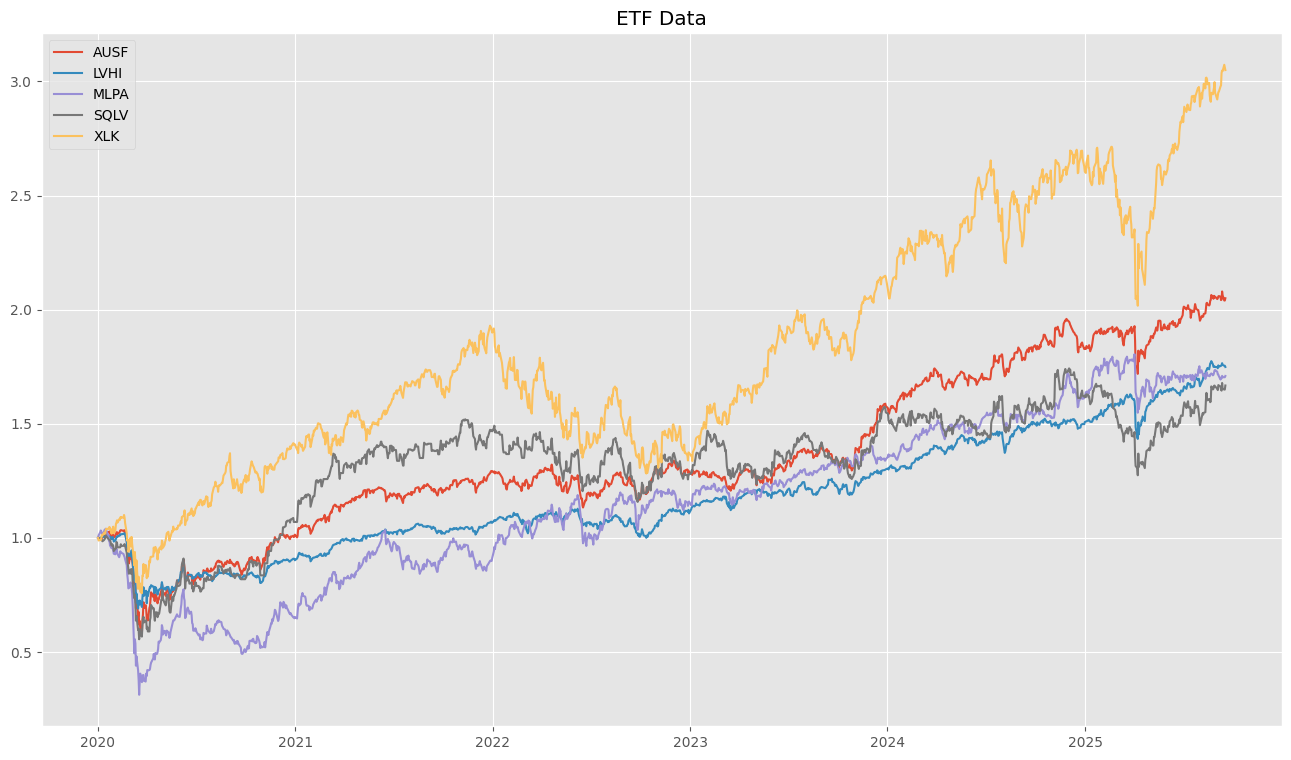

In [2]:
freq = "1d"
tickers = ['AUSF','LVHI', 'SQLV','MLPA','XLK']
start = '2020-01-01'
end = date.today()
prices = data_yahoo(tickers,freq, start, end, ['Adj Close'], False)
display(prices)
prices = fix_na_data_yahoo(prices)
prices = normalize_data(prices, False, 1, True, True)
returns = prices.pct_change().dropna()

### Backtest of diversification algorithm

##### Try rebalancing with stop loss and take profit

backtesting ew_cap_floor strategy using a thresholds (% return) of [0.1, 0.1]
using cash_bank as safe asset...


c:\Users\germa\Documents\Python\dynamic_asset_allocation\python_scripts\diversification.py:56: RuntimeWarning: invalid value encountered in divide
  return (da/da_rebal - 1 > self.threshold[0]) | (da/da_rebal - 1 < -self.threshold[1])
c:\Users\germa\Documents\Python\dynamic_asset_allocation\python_scripts\diversification.py:56: RuntimeWarning: divide by zero encountered in divide
  return (da/da_rebal - 1 > self.threshold[0]) | (da/da_rebal - 1 < -self.threshold[1])


using RETURNS...
--- 0.6306841373443604 seconds ---


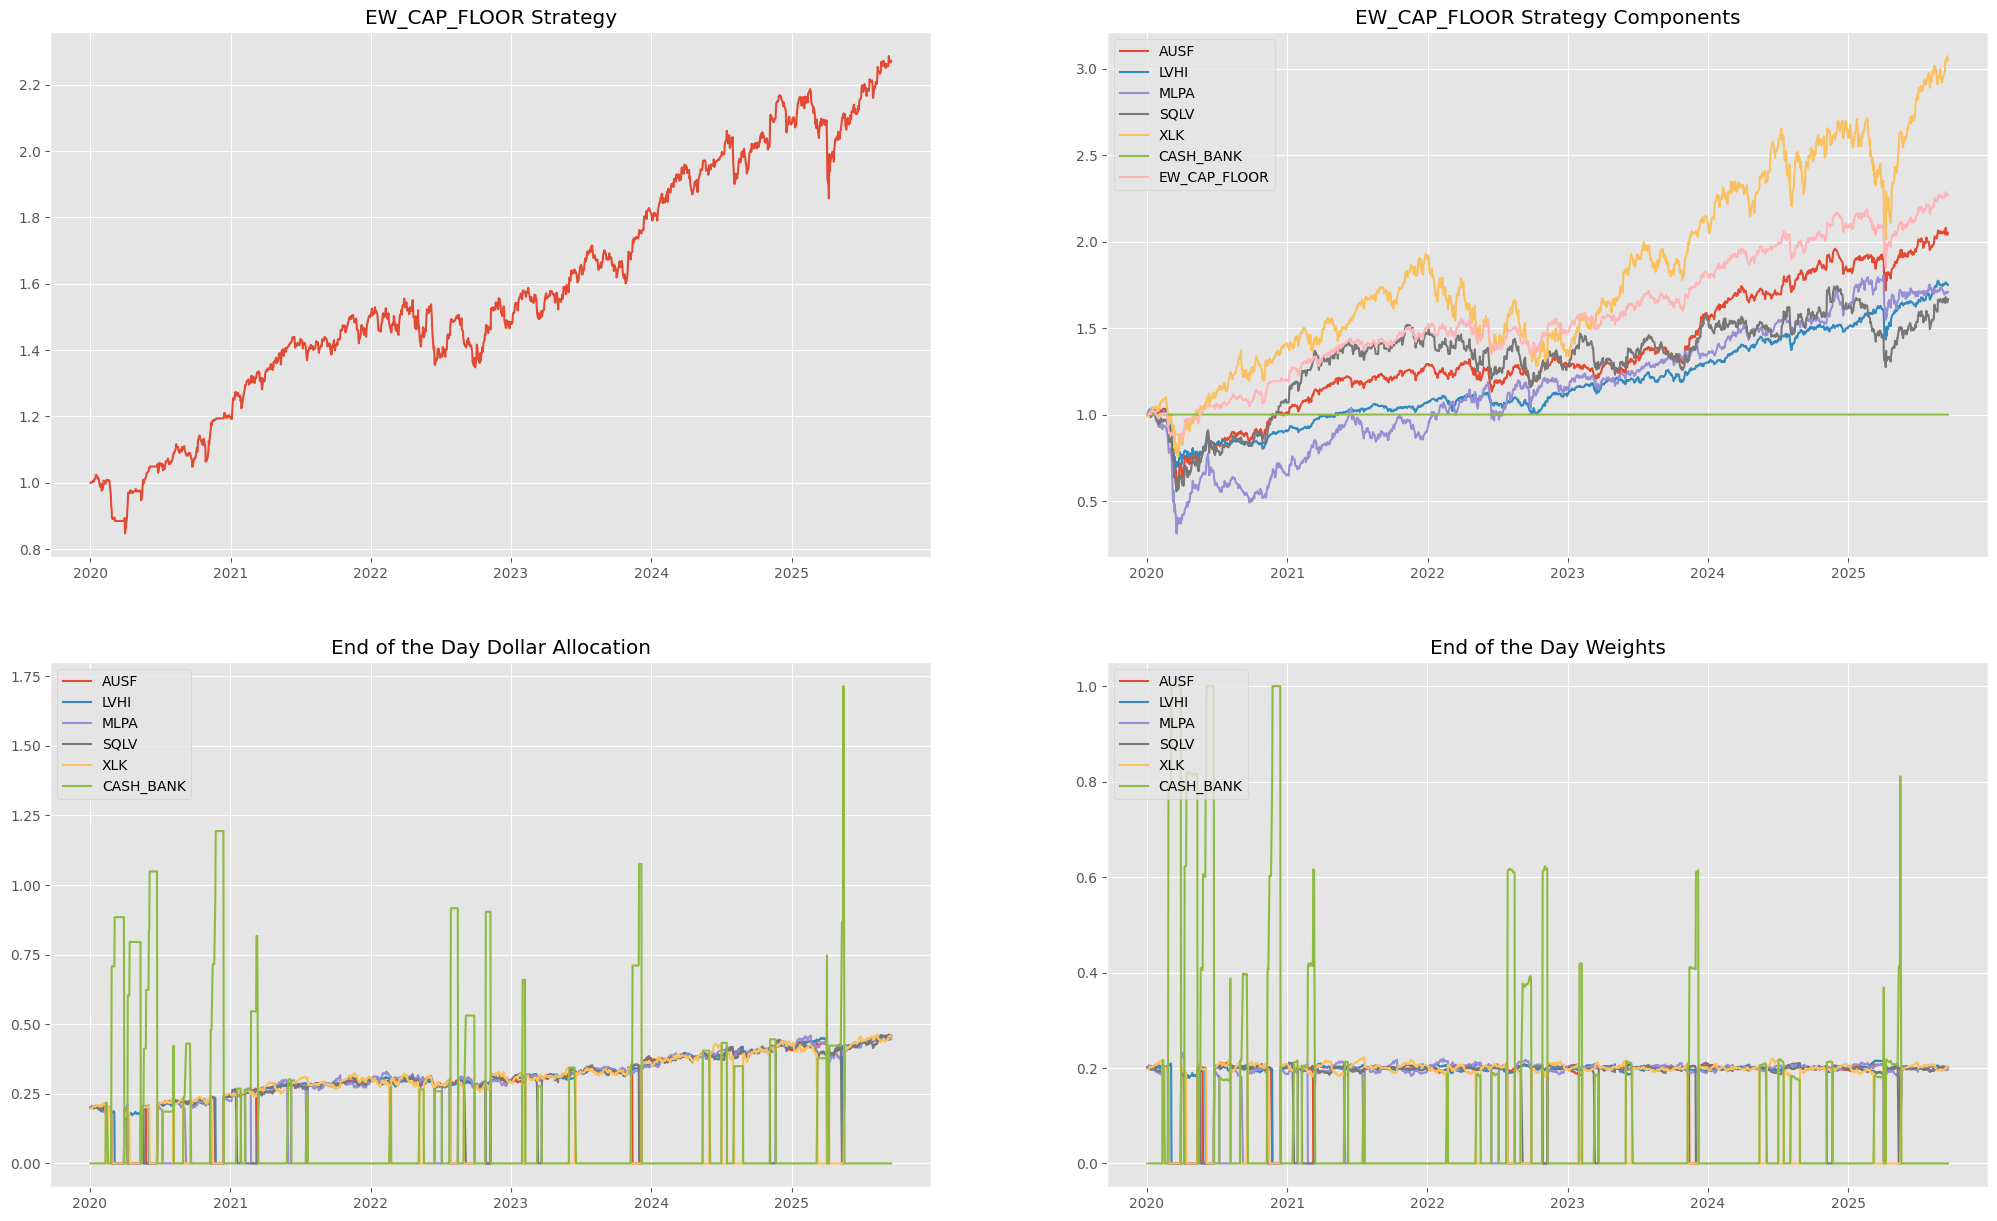

In [3]:
trigger_simulation = TriggerSimulation(returns, allocation_type='ew_cap_floor',safe_asset='cash_bank',
                                       threshold=[0.1,0.1], window=0, rebal = 30)
backtest_results = trigger_simulation.trigger_simulation()

### Dynamic Asset Allocation

In [4]:
m=3.0
start_value=float(1)
kappa=0.8
window=0
rebal = 1
w_bounds=[0,1]
are_returns = True
plot = True

In [5]:
daa = pd.concat([pd.DataFrame(returns['XLK']) , backtest_results['portfolio_value'].pct_change().dropna()], axis = 1)

Summary: 
 strategy: Relative Maximum Drawdown 
 m = 3.0 
 kappa: 0.8 
             rebalancing frequency: 1 
 weight bounds: [0, 1]
using RETURNS...


c:\Users\germa\Documents\Python\dynamic_asset_allocation\python_scripts\dynamic_asset_allocation.py:256: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.history.iloc[0][self.account_name] = self.start_value
c:\Users\germa\Documents\Python

--- 3.114305257797241 seconds ---


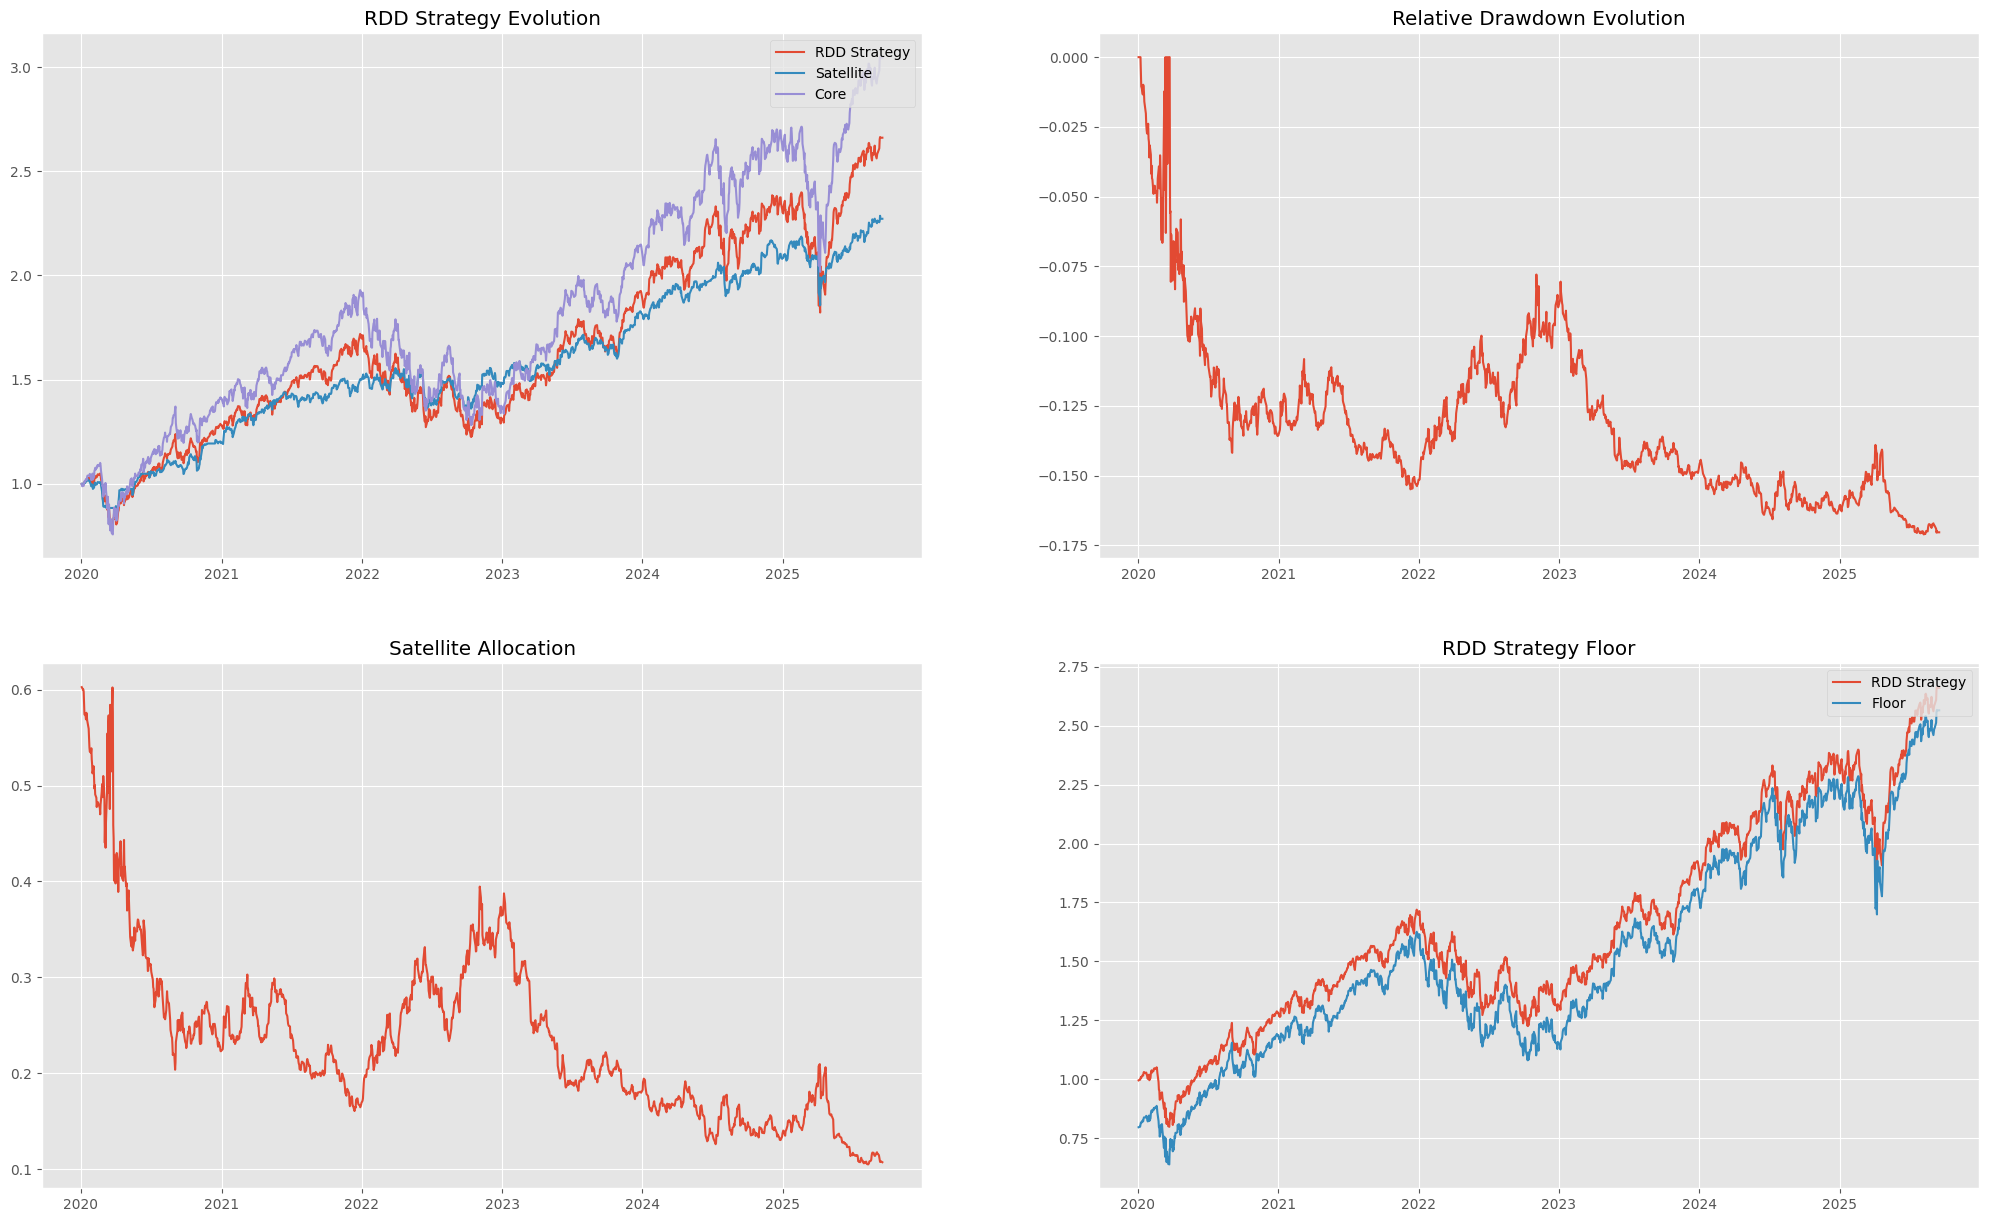

In [6]:
sat_core = False
strategy_type = 'rdd'
strategy_name = strategy_type + '_account'
daa_simulation = DAASimulation(daa, strategy_type, m, kappa, rebal,start_value, window,  sat_core, w_bounds, are_returns, plot)
backtest_result = daa_simulation.daa_simulation()  
results = returns.join(backtest_result['history'][strategy_name].pct_change().dropna(), on = 'Date')

In [7]:
results = performance_metrics(results, ALL_ABS_METRICS, round_to=5)

using RETURNS...
ratio_metric: estimating sharpe_ratio using target of 0.05
value_at_risk: VaR estimated using a cornish_fisher assumption and a confidence level of: 95.0%
ratio_metric: estimating c_f_var_ratio using target of 0.05
value_at_risk: VaR estimated using a cornish_fisher assumption and a confidence level of: 95.0%
value_at_risk: VaR estimated using a sample assumption and a confidence level of: 95.0%
ratio_metric: estimating sample_var_ratio using target of 0.05
value_at_risk: VaR estimated using a sample assumption and a confidence level of: 95.0%
ratio_metric: estimating cvar_ratio using target of 0.05
using RETURNS...
ratio_metric: estimating calmar_ratio using target of 0.05
using RETURNS...
using RETURNS...
ratio_metric: estimating sterling_ratio using target of 0.05
using RETURNS...
using RETURNS...
ratio_metric: estimating burke_ratio using target of 0.05
using RETURNS...
using RETURNS...
ratio_metric: estimating modified_burke_ratio using target of 0.05
using RETURN

,total_return,annualized_returns,annualized_volatility,sharpe_ratio,skewness,kurtosis,normal_test,value_at_risk,c_f_var_ratio,value_at_risk,...,sortino_ratio,kappa_risk_measure,kappa_ratio,gain_loss_ratio,upside_potential_ratio,omega_ratio_sum_approx,omega_ratio_put_option,sortino_ratio,kappa_ratio,sharpe_ratio
AUSF,1.04986,0.13464,0.21287,0.37872,-0.76556,19.77480,0.0,0.01807,4.46255,0.01659,...,0.82175,0.25952,0.31099,1.10114,0.04403,1.10114,1.10351,0.00406,0.00154,0.02970
LVHI,0.74903,0.10338,0.15843,0.32096,-1.74730,24.10265,0.0,0.01490,3.41368,0.01256,...,0.58677,0.24192,0.21047,1.08534,0.03611,1.08534,1.08788,0.00285,0.00102,0.02477
MLPA,0.70946,0.09895,0.33040,0.14109,-2.31680,44.36050,0.0,0.02534,1.83951,0.02330,...,0.37416,0.31780,0.14675,1.06956,0.05009,1.06956,1.07066,0.00327,0.00128,0.01954
SQLV,0.66788,0.09420,0.26747,0.15738,0.13068,6.56318,0.0,0.02332,1.80483,0.02444,...,0.39322,0.26183,0.16101,1.05696,0.05274,1.05696,1.05810,0.00285,0.00117,0.01813
XLK,2.04585,0.21653,0.28219,0.56211,0.03833,8.39243,0.0,0.02401,6.60545,0.02603,...,1.43135,0.26726,0.59436,1.12736,0.05908,1.12736,1.12930,0.00670,0.00278,0.04176
cash_bank,0.00000,0.00000,0.00000,-inf,NaN,NaN,NaN,NaN,NaN,-0.00000,...,-54.33718,0.05785,-5.20019,0.00000,0.00000,0.00000,-251.02430,-0.22091,-0.02114,-inf
rdd_account,1.66089,0.18794,0.22697,0.57890,0.03901,5.41284,0.0,0.02014,6.52453,0.02234,...,1.31663,0.24410,0.53942,1.12139,0.05456,1.12139,1.12358,0.00593,0.00243,0.04141


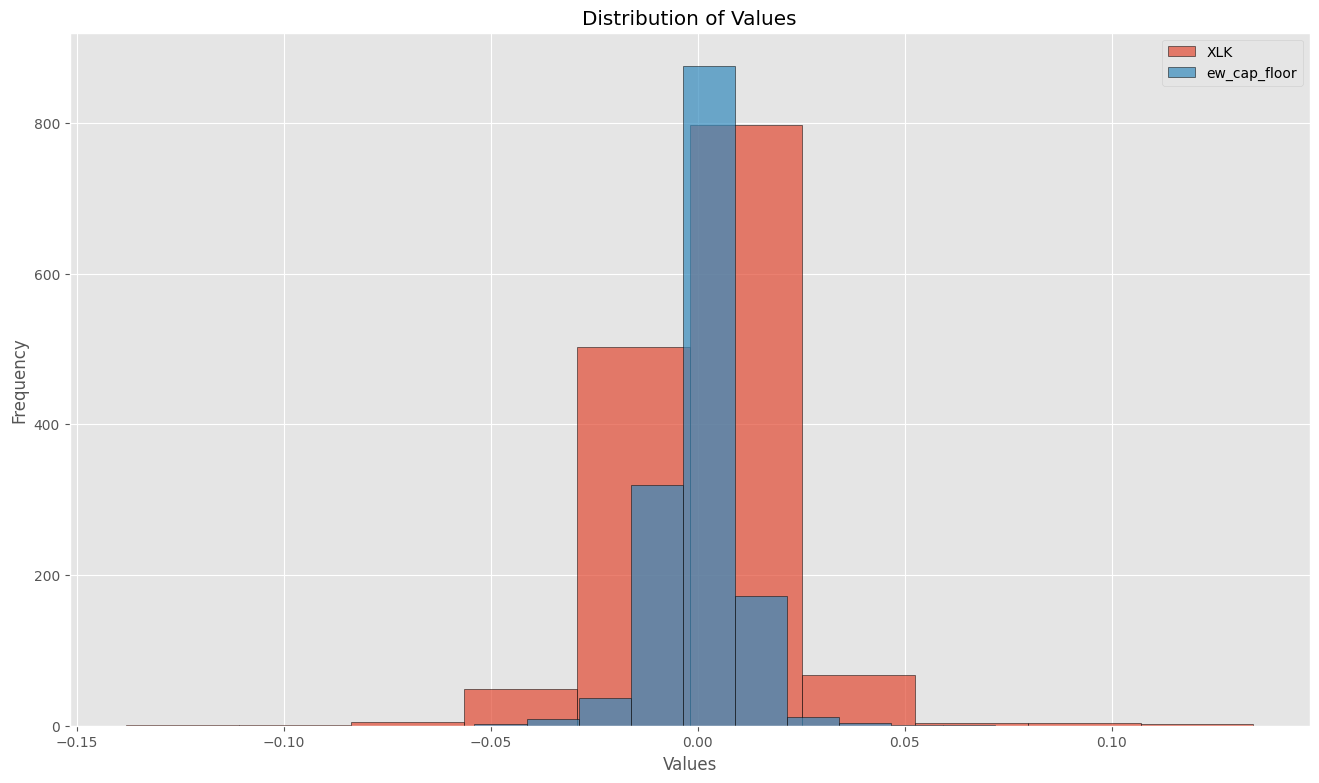

In [8]:
plot_distribution(daa,overlap=True)